In [1]:
import warnings
import xgboost as xgb

import pandas as pd
import os
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
xgb_clf = xgb.XGBClassifier()

print(xgb_clf)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [3]:
hr_df = pd.read_csv("train.csv")
hr_df.head(5)

,Subject,p1AFx,p2AFx,p1AFy,p2AFy,p1AFz,p2AFz,p1AMx,p2AMx,p1AMy,...,mHPx,mHPy,mHPz,SA_Aver,CO_Aver,TR_Aver,SA_RMS,CO_RMS,TR_RMS,Foot Contact Strategy
0,JJY,9.692958,8.905324,-2.465751,-3.702954,1.342814,3.839608,1034.571628,1334.764158,106.554885,...,0.091310,-0.097466,0.009338,6.113038,6.100031,0.627007,6.871661,6.859238,0.707372,0
1,KKM,9.403190,8.047242,-2.046872,-5.264078,1.460613,4.690748,1073.346733,1319.043960,175.543693,...,-0.007827,-0.034618,0.001151,7.022235,6.995664,0.887663,7.296192,7.271831,0.899381,0
2,KTY,11.761998,8.844850,-1.575456,-3.358868,-2.401069,1.570222,580.468154,1282.811834,-111.221858,...,0.037844,-0.150304,-0.011258,9.180511,9.178420,0.677658,9.607214,9.615042,0.803398,0
3,LGW,8.759115,11.071866,-1.290551,-3.673267,-1.402135,3.076698,560.999457,1601.602891,-81.847440,...,0.007061,-0.102380,-0.014187,3.537238,3.522917,0.305105,3.765374,3.755657,0.345589,0
4,LJK,8.585421,10.075583,-0.799774,-1.675821,-2.689660,1.874648,-223.772000,1242.421621,-137.400103,...,-0.095650,-0.006813,0.020877,6.013928,6.011873,0.610182,6.364540,6.364365,0.657645,0


In [4]:
colnames = ['p1KFx','p2KFx','p1KFy','p2KFy','p1KFz','p2KFz','p1KMx','p2KMx','p1KMy','p2KMy','p1KMz','p2KMz','p1KPx','p2KPx','p1KPy','p2KPy','p1KPz','p2KPz','mKFx','mKFy','mKFz','mKMx','mKMy','mKMz','mKPx','mKPy','mKPz']
X, y = hr_df[colnames], hr_df[['Foot Contact Strategy']]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=777)

In [5]:
xgb_model = xgb.XGBClassifier(booster='gbtree',
                              scale_pos_weight=1,
                              learning_rate=0.0005,  
                              colsample_bytree = 0.4,
                              subsample = 0.8,
                              objective='binary:logistic', 
                              n_estimators=100, 
                              max_depth=3, 
                              gamma=10, 
                              seed=777)

In [6]:
hr_dmatrix = xgb.DMatrix(data=hr_df[colnames], label=hr_df[['Foot Contact Strategy']])

cv_params = {"objective":"binary:logistic", 
             "max_depth":5}

hr_cv = xgb.cv(dtrain=hr_dmatrix, 
               params=cv_params, 
               nfold=6, 
               num_boost_round=100, 
               metrics="auc", 
               as_pandas=True)

hr_cv.head(5)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.955689,0.018767,0.858796,0.155162
1,0.996029,0.004100,0.905092,0.138985
2,0.996946,0.002300,0.905092,0.138985
3,0.997607,0.002504,0.923611,0.100714
4,1.000000,0.000000,0.923611,0.100714


    Foot Contact Strategy
16                      0
15                      0
22                      1
11                      0
33                      1
12                      0
3                       0
9                       0
35                      1
30                      1
17                      0
34                      1 

 [0 1 1 0 1 0 0 0 1 1 0 1] 


              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.83      1.00      0.91         5

    accuracy                           0.92        12
   macro avg       0.92      0.93      0.92        12
weighted avg       0.93      0.92      0.92        12



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


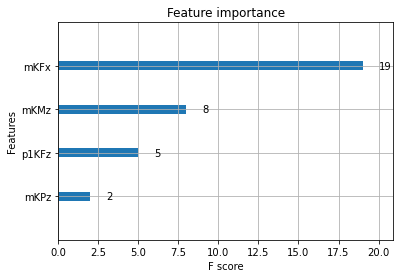

In [7]:
hr_pred = xgb_model.fit(X_train, y_train).predict(X_test)
print(y_test,'''

''',hr_pred,'''

''')
print(classification_report(y_test,hr_pred))

xgb.plot_importance(xgb_model)

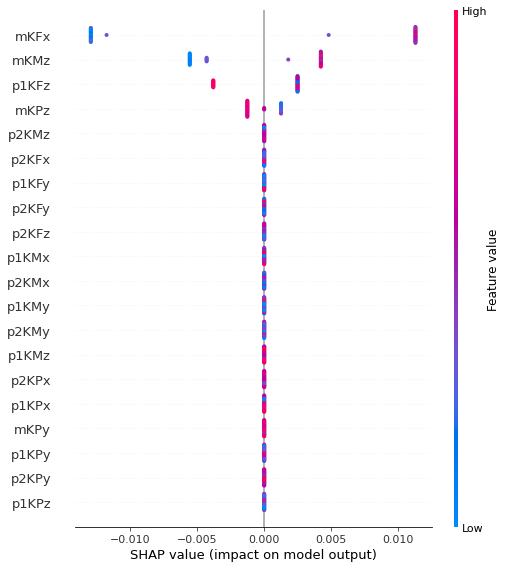

In [8]:
# load JS visualization code to notebook
shap.initjs()

svalue = shap.TreeExplainer(xgb_model).shap_values(X)

shap.summary_plot(svalue, X)

In [9]:
X, y = hr_df[colnames], hr_df[['Foot Contact Strategy']]
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [11]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [12]:
shap.force_plot(explainer.expected_value, shap_values, X)

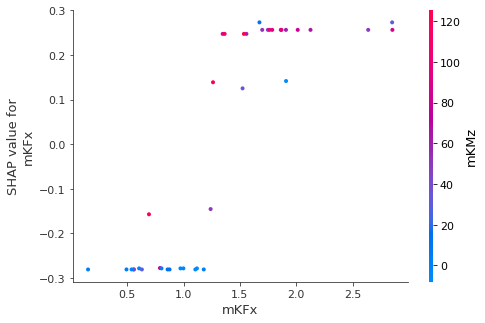

In [13]:
shap.dependence_plot("mKFx", shap_values, X)

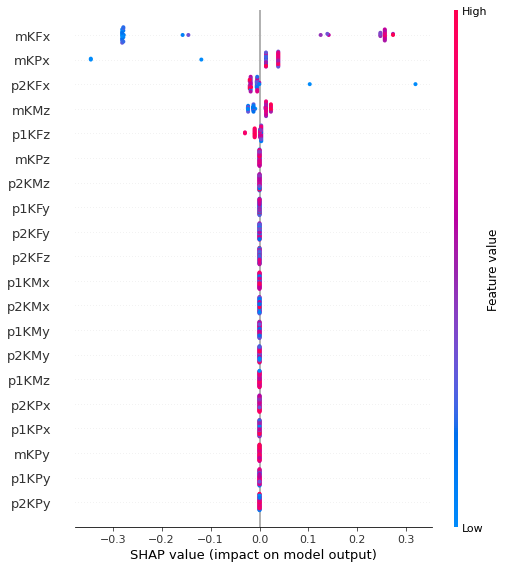

In [14]:
shap.summary_plot(shap_values, X)

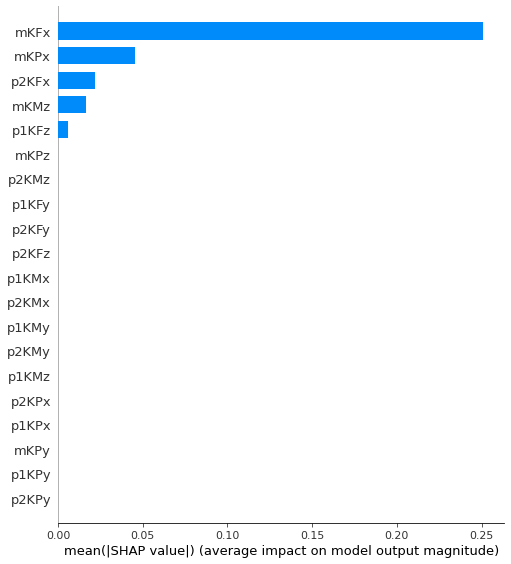

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar")